/home/liusong


/home/liusong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
/usr/local/python3/lib/python3.7/contextlib.py:119: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


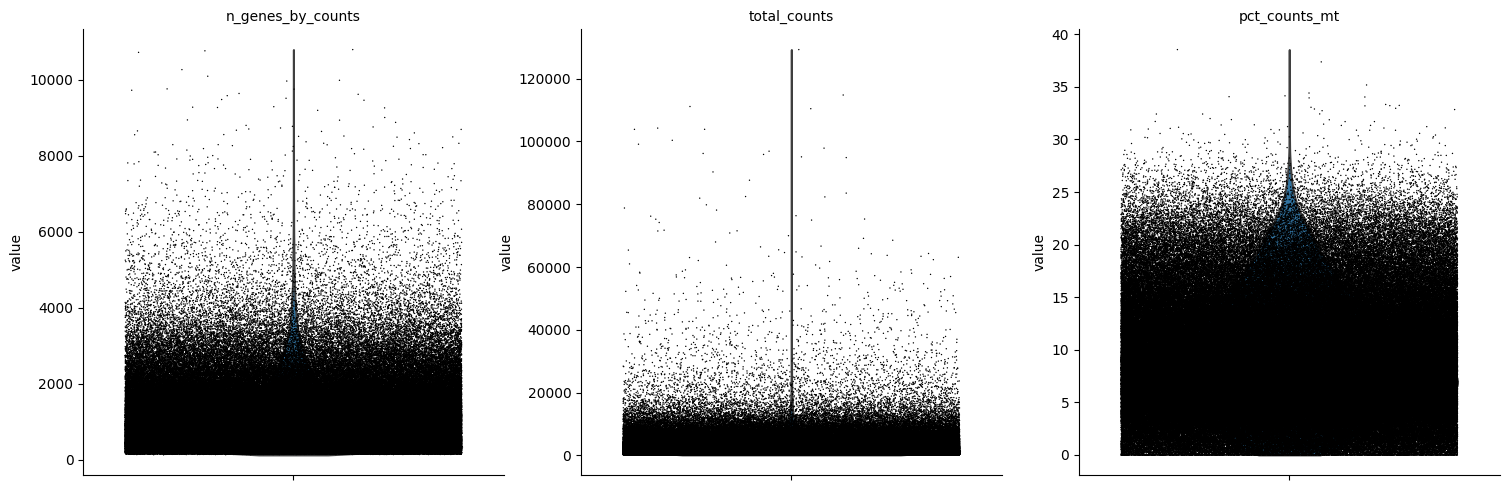

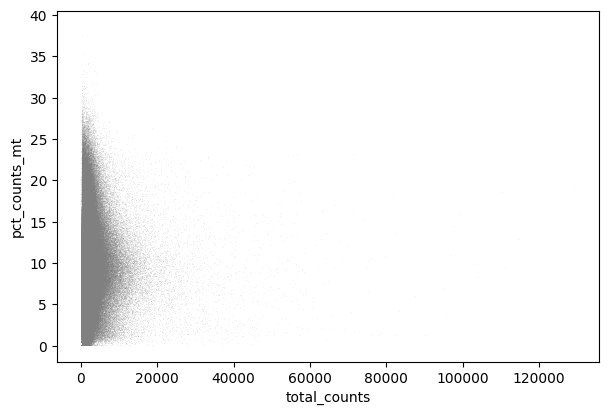

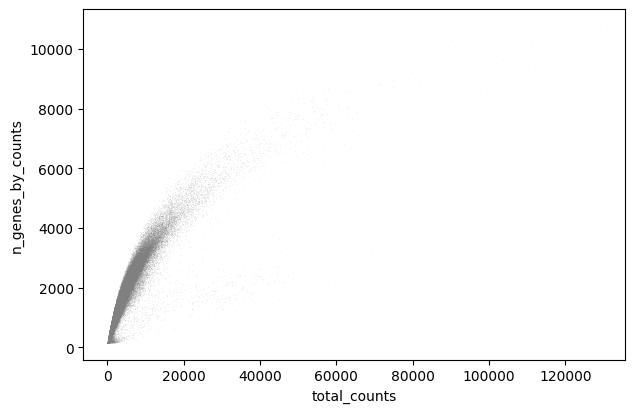

In [15]:
import numpy as np
import pandas as pd
import scanpy as sc
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import scanpy.external as sce
import bbknn
import os
import anndata as ad
print (os.getcwd())
os.chdir("/home/liusong/scRNA/endometriosis/V3data/Downloaded_scRNA_data/NG_EMS/Reanalysis2024")

alldata=sc.read_h5ad("NG_alldata2024.h5ad")
alldata
ribosomes=alldata.var_names.str.match("^RP[LS]")
alldata=alldata[:,~ribosomes]

alldata.var['mt']=alldata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(alldata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(alldata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],jitter=0.4, multi_panel=True)
sc.pl.scatter(alldata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(alldata, x='total_counts', y='n_genes_by_counts')
sc.pp.normalize_total(alldata, target_sum=1e4)
sc.pp.log1p(alldata)

NGOV=sc.read_h5ad("NG_OV_umap_leiden_BBKNN.h5ad")
NGOV.obs
NGEU=sc.read_h5ad("NG_EU_umap_leiden_BBKNN.h5ad")
NGEU.obs
NGOMA=sc.read_h5ad("NG_OMA_umap_leiden_BBKNN.h5ad")
NGOMA.obs
NGPEM=sc.read_h5ad("NG_PEM_umap_leiden_BBKNN.h5ad")
NGPEM.obs
NGOMA.obs['newcelltype']=NGOMA.obs['celltype']


/home/liusong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  after removing the cwd from sys.path.


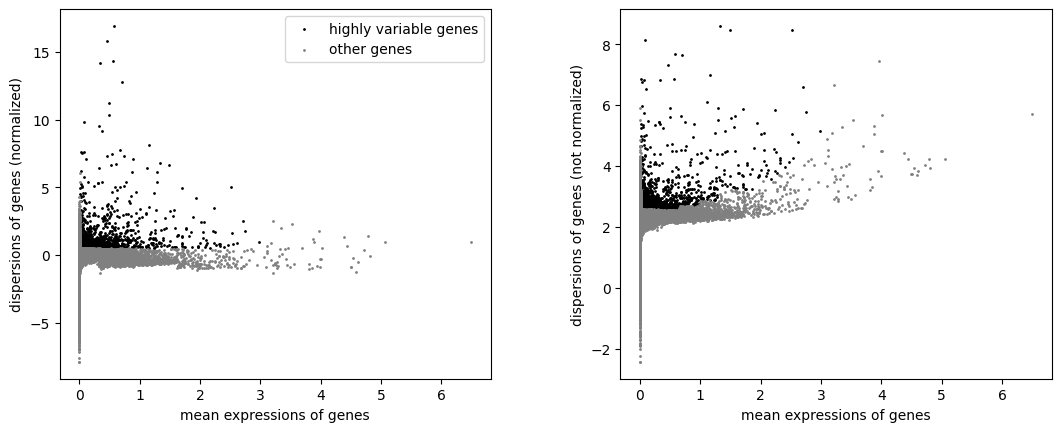

/home/liusong/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


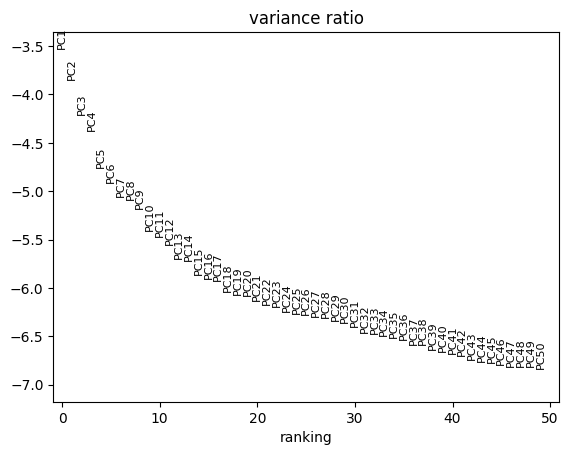

In [16]:
NGdata=[NGEU,NGPEM,NGOMA,NGOV]
NGdata=ad.concat(NGdata,merge="same")
adata=alldata[NGdata.obs_names,:]
adata.obs['newcelltype']=NGdata.obs['newcelltype']

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)
adata.raw = adata

adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

adata.obs['sampleID']=adata.obs_names.str.lstrip('ATCG-')
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=50)
#adata.write("NG_4groups_pca_results.h5ad")


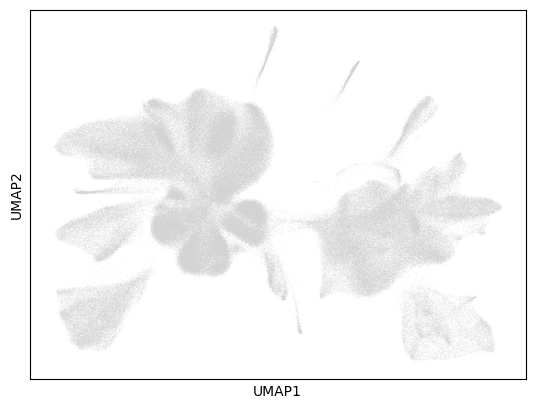

In [17]:
bbknn.bbknn(adata,batch_key='sampleID')
sc.tl.umap(adata)
sc.pl.umap(adata)
sc.tl.leiden(adata)
adata.write("NGdata_4groups_umap_leiden.h5ad")


/home/liusong/.local/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


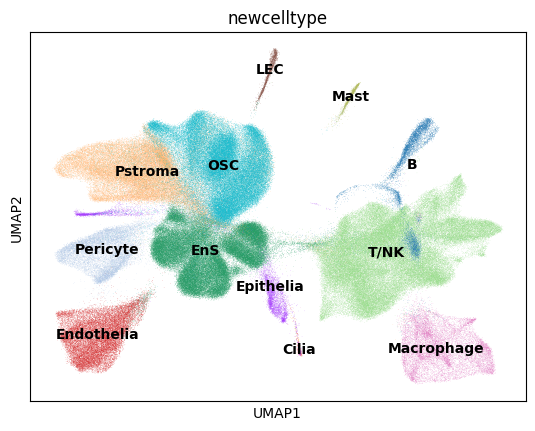

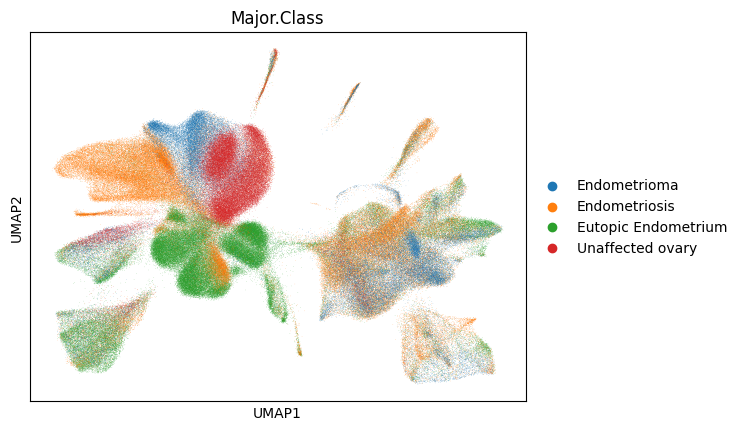

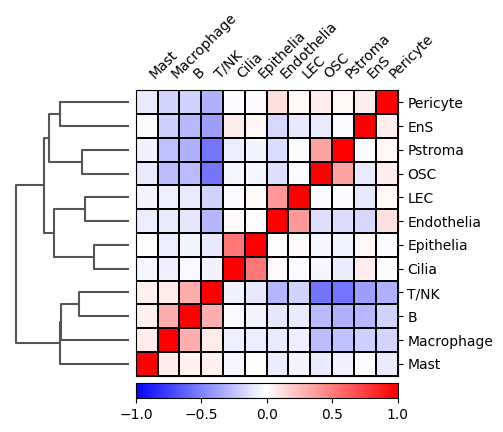

/home/liusong/.local/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


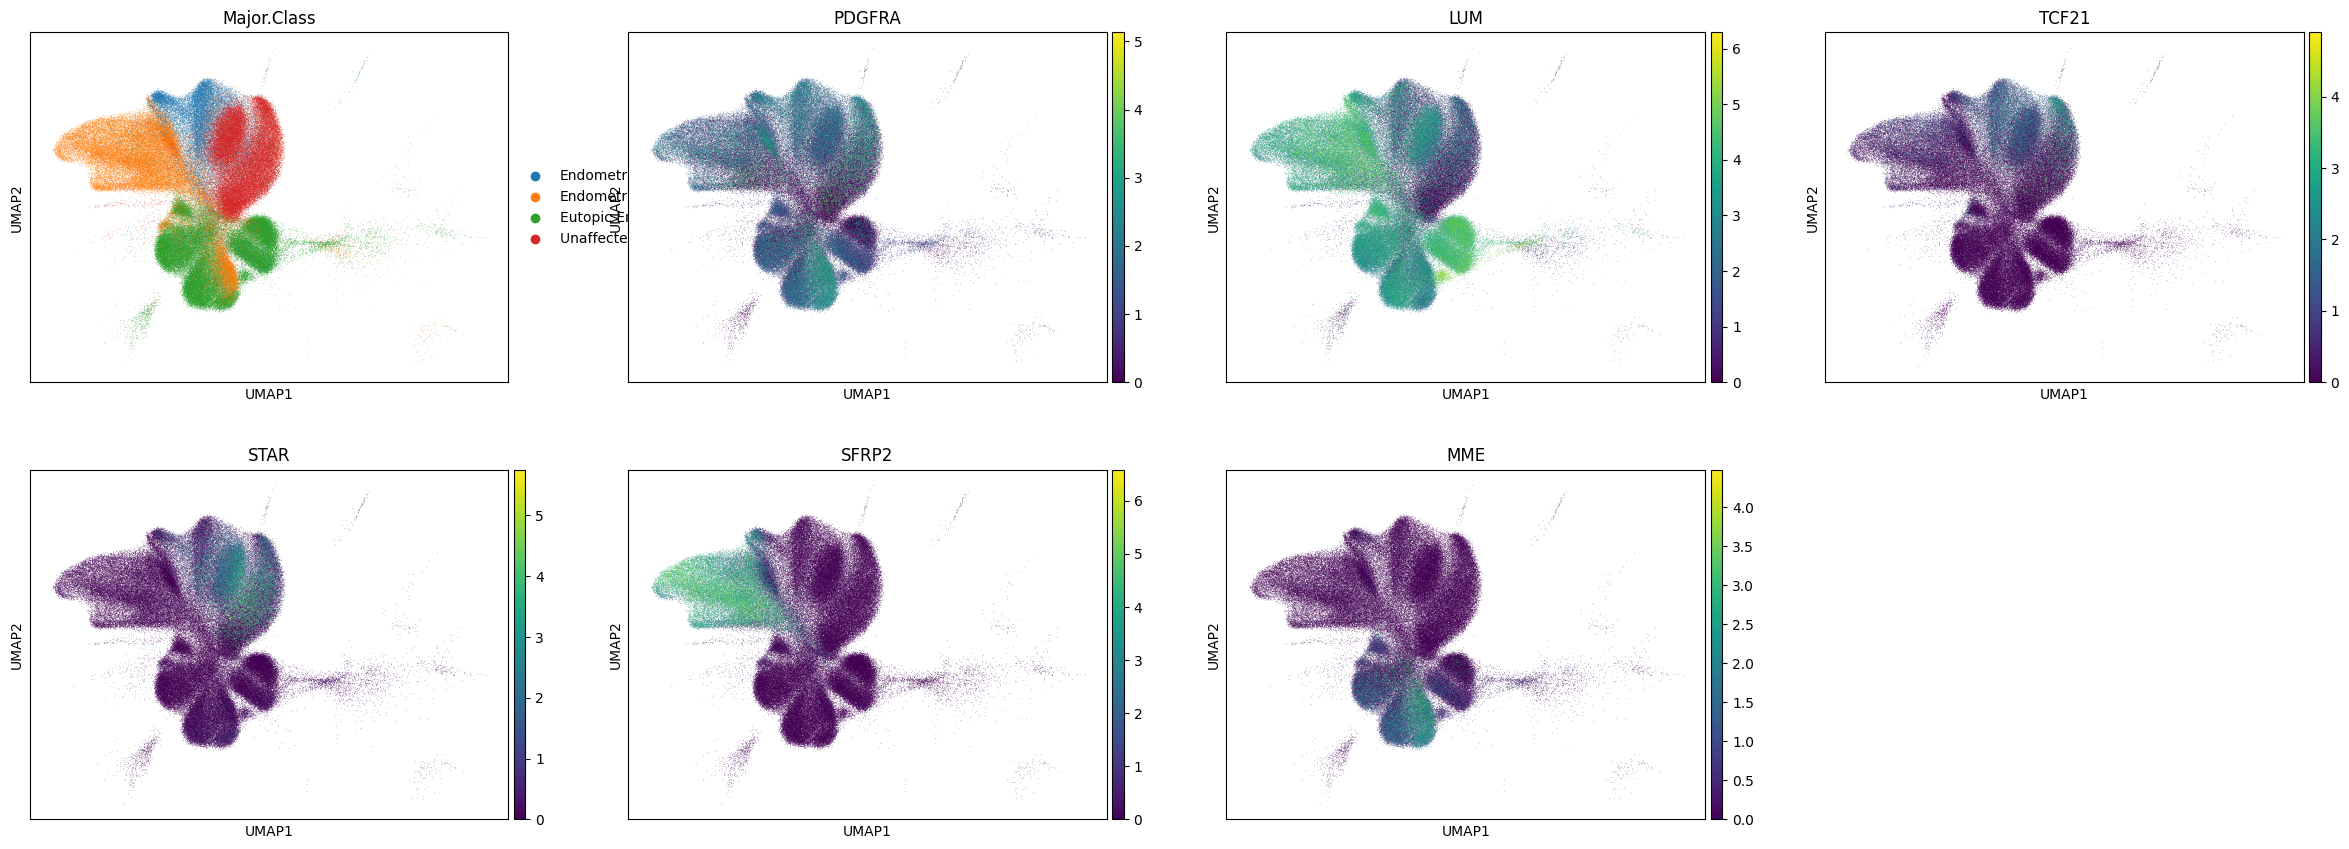

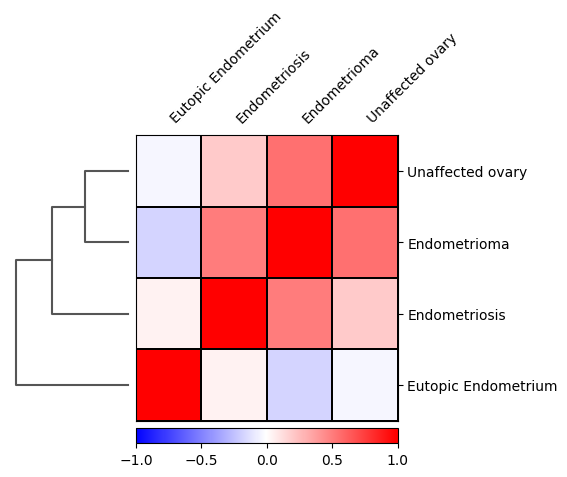

In [20]:
tdata=adata[adata.obs['newcelltype'] != "Erythrocyte",]
sc.pl.umap(tdata,color=['newcelltype'],legend_loc="on data")
sc.pl.umap(tdata,color=['Major.Class'])
sc.tl.dendrogram(tdata,'newcelltype')
sc.pl.correlation_matrix(tdata,'newcelltype',figsize=(5,4),save="NG_4group_data_celltypes_correlation.pdf")
stroma=adata[adata.obs['newcelltype'].isin(['Pstroma','OSC','EnS']),]
sc.pl.umap(stroma,color=['Major.Class','PDGFRA','LUM','TCF21','STAR','SFRP2','MME'])
sc.tl.dendrogram(stroma,'Major.Class')
sc.pl.correlation_matrix(stroma,'Major.Class',figsize=(5,4),save="NG_4group_stroma_correlation.pdf")